# Step1: Biometric using Hand Geometry

In [2]:
from PIL import Image
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import binascii
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import imutils


In [3]:
def displayImage(name,data):
 
    '''
     Input:- Image-name, image-path to be display
     Output:- Display image on separate window
 
    '''
    cv2.imshow(name, data)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Step 1a): Image Preprocessing

In [4]:
'''
 --Acquired the coloured hand image
 --resize the image 
 --rotate the image by -90-degree
 
'''
originalImage = cv2.imread('hand.jpg')
resizedImage1 = cv2.resize(originalImage, (200,200))
resizedImage = imutils.rotate(resizedImage1, -90)
displayImage("resized",resizedImage)


In [5]:
'''
  convert the hand-image into Gray image 
  
'''
#convert the image into GrayImage
grayImage = cv2.cvtColor(resizedImage, cv2.COLOR_BGR2GRAY)

#convert the image into black and white
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
 
displayImage('Black white image', blackAndWhiteImage)
displayImage('Original image',resizedImage)
displayImage('Gray image', grayImage)

In [6]:
'''
Gaussian filter had used to remove the background noise of the image

'''
#median filter 
median = cv2.medianBlur(resizedImage, 5)
compare = np.concatenate((resizedImage, median), axis=1) #side by side comparison
displayImage('img', compare)

#gaussian filtering
blur = cv2.GaussianBlur(grayImage,(5,5),0)
displayImage("Gaussianblur",blur)


In [7]:
'''
hand image is changed over to the “binary image” by thresholding
# applying Otsu thresholding 
# as an extra flag in binary  
# thresholding
'''
ret, thresh1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY +  cv2.THRESH_OTSU) 
displayImage('Otsu Threshold', thresh1)          

ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Step 1b): Feature Extraction


In [8]:
'''
Boundary Tracing of the preprocessed hand image
-trace contours of image used to plot all the contours point
'''

cnts = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(cnts)

cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)


# determine the most extreme points along the contour
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# draw the outline of the object, then draw each of the
# extreme points, where the left-most is red, right-most
# is green, top-most is blue, and bottom-most is teal
cv2.drawContours(thresh1, [c], -1, (125, 125, 125), 2)
cv2.circle(thresh1, extLeft, 8, (50, 100, 200), -1)
cv2.circle(thresh1, extRight, 8, (100, 50, 80), -1)
cv2.circle(thresh1, extTop, 8, (50, 50, 50), -1)
cv2.circle(thresh1, extBot, 8, (50, 50, 50), -1)

displayImage("Image", thresh1)




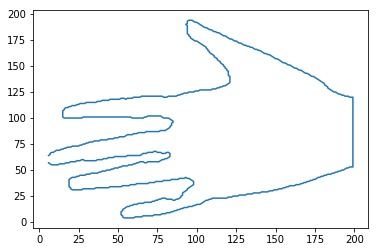

In [9]:
#print all the contours point
#remove
#print(cnts)
items = [tuple(item[0]) for npar in cnts for item in npar]

#print(items)

xRes = [lis[0] for lis in items]
yRes = [lis[1] for lis in items]

plt.plot(yRes,xRes)


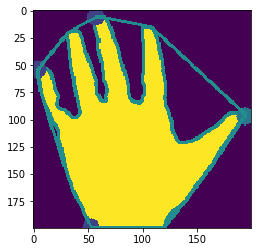

In [10]:
'''
- Detect the convex contour
- find the X-Y coordinates of hand image
- find convex hull
'''

hull = cv2.convexHull(cnts[0])

#print(hull)

xhull = [item[0] for sublist in hull for item in sublist]
yhull = [item[1] for sublist in hull for item in sublist]
#print('convexHull-X-coord:= ',xhull)
#print('convexHull-Y-coord:= ',yhull)

img_copy = thresh1.copy()
img_hull = cv2.drawContours(img_copy, contours = [hull], 
                            contourIdx = 0, 
                            color = (125, 125, 125), thickness = 2)
plt.imshow(img_hull)



In [11]:
'''
- find the coordinates of center point for hand image
- highlight the center point
'''
# calculate moments of binary image
M = cv2.moments(th3)
 
# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
#print("cX",cX) 
#print("cY",cY) 

# put text and highlight the center
cv2.circle(th3, (cX, cY), 5, (125, 125, 255), -1)
cv2.putText(th3, "centroid", (cX - 25, cY - 25),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
 
# display the image
displayImage("Image", th3)


Text(0,0.5,'xhull')

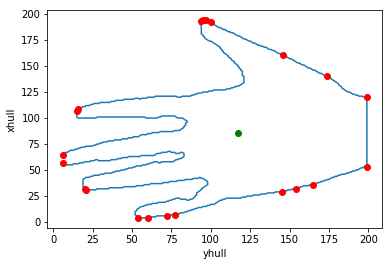

In [12]:
'''
- plot the X-Y coordinates of contours point and center point
'''
plt.plot(yRes,xRes)
plt.plot(yhull,xhull,'ro')
plt.plot(cY,cX,'go')
plt.xlabel("yhull")
plt.ylabel("xhull")


Text(0,0.5,'xhullupdated')

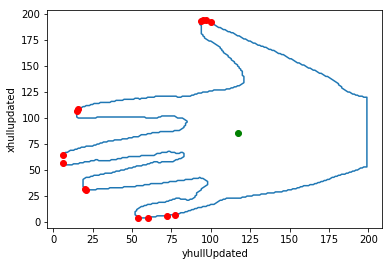

In [13]:
'''
 To find the tips point from hand geometry
 Consider the points above the center point which indicate the tip points
'''

#only take the coordinates of tip points
xhullUpdated = []
yhullUpdated = []
t=0;
for i in yhull:
    if(i<cY):
        yhullUpdated.append(i)
        xhullUpdated.append(xhull[t])
    t=t+1

plt.plot(yRes,xRes)
plt.plot(yhullUpdated,xhullUpdated,'ro')
plt.plot(cY,cX,'go')
plt.xlabel("yhullUpdated")
plt.ylabel("xhullupdated")

#print('yhullUpdated',yhullUpdated)
#print('xhullUpdated',xhullUpdated)

# Step 1c): Key Generation

In [14]:
'''
Euclidean distance between center point and all other points of convex hull(tips point)

'''
distVector = []
length=int(len(yhullUpdated))
for i in range(length):
    distVector.append(np.sqrt( (xhullUpdated[i]-cX)**2 + (yhullUpdated[i]-cY)**2 ))
    #distVector.append(dist)

#print(distVector)

In [15]:
'''
Variance and standard deviation is calculated for pairwise Euclidean distance
'''
import statistics 

variance = statistics.variance(distVector)
std_dev = statistics.stdev(distVector)
print("Variance of sample set is % s"  %(variance))
print("Standard Deviation of sample is % s " %(std_dev)) 

Variance of sample set is 59.81944190387565
Standard Deviation of sample is 7.734302935874418 


In [16]:
'''
Unique 3 digit key generation
Key= (Most Significant 1 Digits of p1) * 10 + (Least Significant 1 Digits p2)
Where
P1 = variance of Hand points pairs wise distance
P2 = standard deviation of Hand points pairs wise distance

'''
MSB = int(str(variance)[:1])
LSB = int(str(std_dev)[-1:])
#print(MSB,LSB)
key = (MSB)* 10 + (LSB)
print("Key Generated:- ",key)

Key Generated:-  58


# Step2:- Encrypt Msg using Ceaser Cipher


In [17]:
hand_key = key
Number = hand_key
Sum = 0
while(Number > 0):
    r = Number % 10
    Sum = Sum + r
    Number = Number//10
#print(Sum)

In [18]:
def encrypt(text,s):
    result = ""
    #print("lrngth" , len(text))
    for i in range(len(text)):
        char = text[i]
        # Encrypt uppercase characters in plain text
        if (char.isupper()):
            result += chr((ord(char) + s-65) % 26 + 65)
        # Encrypt lowercase characters in plain text
        else:
            result += chr((ord(char) + s - 97) % 26 + 97)
    return result

text = input("Enter data to be encoded(Without Space) : ") 
#print ("Plain Text : " + text)
#print ("Shift pattern : " + str(Sum))
print ("Cipher-Msg: " + encrypt(text,Sum))


Enter data to be encoded(Without Space) : Steganography
Cipher-Msg: Fgrtnabtencul


# Step 3: Image Steganography using LSB


In [19]:
def to_bin(data):
    """Convert `data` to binary format as string"""
    if isinstance(data, str):
        return ''.join([ format(ord(i), "08b") for i in data ])
    elif isinstance(data, bytes) or isinstance(data, np.ndarray):
        return [ format(i, "08b") for i in data ]
    elif isinstance(data, int) or isinstance(data, np.uint8):
        return format(data, "08b")
    else:
        raise TypeError("Type not supported.")

In [20]:
'''
- First carrier image or cover image has been read and converted in to array of bits
- the secret message which is in the form of characters are converted in to the “ASCII” values
- ASCII values are converted in to array of bits
- key will gives unique pixel position of cover image to embed the data LSB of particular image pixel of cover object

Output: Stego-image has been generated which contains secret message embedded within cover image.

'''
#res = input("Enter data to be encoded(Without Space) : ") 
res= encrypt(text,Sum)

#data = ''.join(format(ord(i), 'b') for i in res) 
#print("The string after binary conversion : " + data) 
data = to_bin(res)
msg_len = len(data)
#print("msg length",msg_len)
            
    
i=0

with Image.open("source_img.png") as img:
   
    width, height = img.size
    #print(width)
    #print(height)
    #img.show()
    for x in range(key, width):
        for y in range(key, height):
            pixel = list(img.getpixel((x, y)))
            for n in range(0,3):
                if(i < len(data)):
                    pixel[n] = pixel[n] & ~1 | int(data[i])
                    i+=1
                    
            img.putpixel((x,y), tuple(pixel))
            
    
    img.save("source_secret.png", "PNG")
        
        

# Step 4: AES Cryptography (CBC-mode) Encryption

In [21]:
from PIL import Image
from Crypto.Cipher import AES

filename = "source_secret.png"
filename_out = "AES_encrypted_image"
format = "PNG"

#hand_key=5980
key = str(hand_key)*8
#print('key', key)


# AES requires that plaintexts be a multiple of 16, so we have to pad the data
def pad(data):
    return data + b"\x00"*(16-len(data)%16) 
 
# Maps the RGB 
def convert_to_RGB(data):
    r, g, b = tuple(map(lambda d: [data[i] for i in range(0,len(data)) if i % 3 == d], [0, 1, 2]))
    pixels = tuple(zip(r,g,b))
    return pixels
    
def process_image(filename):
    # Opens image and converts it to RGB format for PIL
    im = Image.open(filename)
    data = im.convert("RGB").tobytes()
 
    # Since we will pad the data to satisfy AES's multiple-of-16 requirement, we will store the original data length and "unpad" it later.
    original = len(data) 
 
    # Encrypts using desired AES mode (we'll set it to ECB by default)
    new = convert_to_RGB(aes_cbc_encrypt(key, pad(data))[:original]) 
    
    # Create a new PIL Image object and save the old image data into the new image.
    im2 = Image.new(im.mode, im.size)
    im2.putdata(new)
    
    #Save image
    im2.save(filename_out+"."+format, format)
 

# CBC
def aes_cbc_encrypt(key, data, mode=AES.MODE_CBC):
    IV = "A"*16  #We'll manually set the initialization vector to simplify things
    aes = AES.new(key, mode, IV)
    new_data = aes.encrypt(data)
    return new_data
# ECB
def aes_ecb_encrypt(key, data, mode=AES.MODE_ECB):
    aes = AES.new(key, mode)
    new_data = aes.encrypt(data)
    return new_data
 
process_image(filename)


# Step 5: AES Cryptography (CBC-mode) Decryption


In [22]:
def aes_cbc_decrypt(key, data, mode=AES.MODE_CBC):
    IV = "A"*16 
    aes = AES.new(key, mode, IV)
    decd = aes.decrypt(data)
    return decd


def decrypt_image(filename):
    # Opens image and converts it to RGB format for PIL
    im = Image.open(filename)
    data = im.convert("RGB").tobytes()
 
    # Since we will pad the data to satisfy AES's multiple-of-16 requirement, we will store the original data length and "unpad" it later.
    original = len(data) 

    # Decrypts using desired AES mode (we'll set it to ECB by default)
    new = convert_to_RGB(aes_cbc_decrypt(key, pad(data))[:original]) 
    
    # Create a new PIL Image object and save the old image data into the new image.
    im3 = Image.new(im.mode, im.size)
    im3.putdata(new)
    
    #Save image
    im3.save(filename_in+"."+format, format)
    

filenames = filename_out+"."+format
filename_in = "AES_decrypted_image"
decrypt_image(filenames)


# Step 6: Data Extraction using LSB

In [23]:
'''
- Embedded secret data has extracted from stego-image
- Extracting secret data the hand key is used

'''
extracted_bin = []
with Image.open("AES_decrypted_image.png") as img:
    width, height = img.size
    byte = []
    for x in range(hand_key, width):
        for y in range(hand_key, height):
            pixel = list(img.getpixel((x, y)))
            for n in range(0,3):
                extracted_bin.append(pixel[n]&1)

data = "".join([str(x) for x in extracted_bin])
msg =''

for i in range(msg_len):
    msg+=str(extracted_bin[i])
#print(msg)

decoded_msg = ''.join(chr(int(msg[i*8:i*8+8],2)) for i in range(len(msg)//8))
print("decoded_msg:= ",decoded_msg)


decoded_msg:=  Fgrtnabtencul


# Step 7: Decrypt Msg using Ceaser Cipher

In [24]:
def decrypt(text,s):
    result = ""
    #print("lrngth" , len(text))
    for i in range(len(text)):
        char = text[i]
        # Encrypt uppercase characters in plain text
        if (char.isupper()):
            result += chr((ord(char) - s-65) % 26 + 65)
        # Encrypt lowercase characters in plain text
        else:
            result += chr((ord(char) - s - 97) % 26 + 97)
    return result

print ("Received_msg : " + decoded_msg)
print ("Decipher: " + decrypt(decoded_msg,Sum))


Received_msg : Fgrtnabtencul
Decipher: Steganography


# Step 8: PSNR

In [25]:
#calculate PSNR
import math
original = cv2.imread('source_img.png')
updated = cv2.imread('source_secret.png',1)

def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(original,updated)
print(d)

105.36680886253231


# Step 9: MSE

In [26]:
#calculate MSE
def mse(original1, contrast1):
    err = np.sum((original1.astype("float") - contrast1.astype("float")) ** 2)
    err /= float(original1.shape[0] * original1.shape[1])
    return err

MSE=mse(original,updated)
print(MSE)

5.669186305024455e-06
